In [1]:
import scanpy as sc
import anndata as ann
import scipy as sci
import pandas as pd
import os
import numpy as np
import seaborn as sns
import episcanpy.api as epi

/home/97212545/anaconda3/envs/scanpy/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
SCRNA_DIR = '../data/chen-2019/P0BrainCortex/rna/'
SCATAC_DIR = '../data/chen-2019/P0BrainCortex/atac/'
META_PATH = '../data/chen-2019/P0BrainCortex/P0BrainCortex.csv'

# MetaData

In [4]:
metadata = pd.read_csv(META_PATH, index_col=0)
metadata.head()

,Batch,Barcode,IdentChar
GGCAATGGCCCT,12A,GGCAATGGCCCT,IP_Eomes
GGAGTCCATGGT,12A,GGAGTCCATGGT,Ex4_Tenm3
GAATCCGTCCCA,12A,GAATCCGTCCCA,Ex4_Tenm3
GGGAAAGTATTG,12A,GGGAAAGTATTG,Ex45_Galntl6
GTCATCCTGAGA,12A,GTCATCCTGAGA,Ex4_Tenm3


# scRNA-seq Data

In [5]:
%%time
scrna = sc.read_10x_mtx(SCRNA_DIR, var_names='gene_symbols', cache=True)
scrna.obs = scrna.obs.join(metadata, how='left', sort=False)
scrna

CPU times: user 212 ms, sys: 16 ms, total: 228 ms
Wall time: 418 ms


AnnData object with n_obs × n_vars = 5081 × 19322
    obs: 'Batch', 'Barcode', 'IdentChar'
    var: 'gene_ids'

In [6]:
scrna.obs.head()

,Batch,Barcode,IdentChar
GGCAATGGCCCT,12A,GGCAATGGCCCT,IP_Eomes
GGAGTCCATGGT,12A,GGAGTCCATGGT,Ex4_Tenm3
GAATCCGTCCCA,12A,GAATCCGTCCCA,Ex4_Tenm3
GGGAAAGTATTG,12A,GGGAAAGTATTG,Ex45_Galntl6
GTCATCCTGAGA,12A,GTCATCCTGAGA,Ex4_Tenm3


In [7]:
scrna.var.head()

,gene_ids
0610005C13Rik,0610005C13Rik
0610007P14Rik,0610007P14Rik
0610009B22Rik,0610009B22Rik
0610009E02Rik,0610009E02Rik
0610009L18Rik,0610009L18Rik


## Data Cleaning

In [8]:
scrna.obs = scrna.obs.rename(columns={'IdentChar': 'cell_type'})

In [9]:
scrna.obs['Batch'] = scrna.obs['Batch'].astype('category')
scrna.obs['cell_type'] = scrna.obs['cell_type'].astype('category')

In [10]:
scrna.var = scrna.var.rename(columns={'gene_ids': 'gene_symbols'})

# Quality Control

In [11]:
scrna.var_names_make_unique()

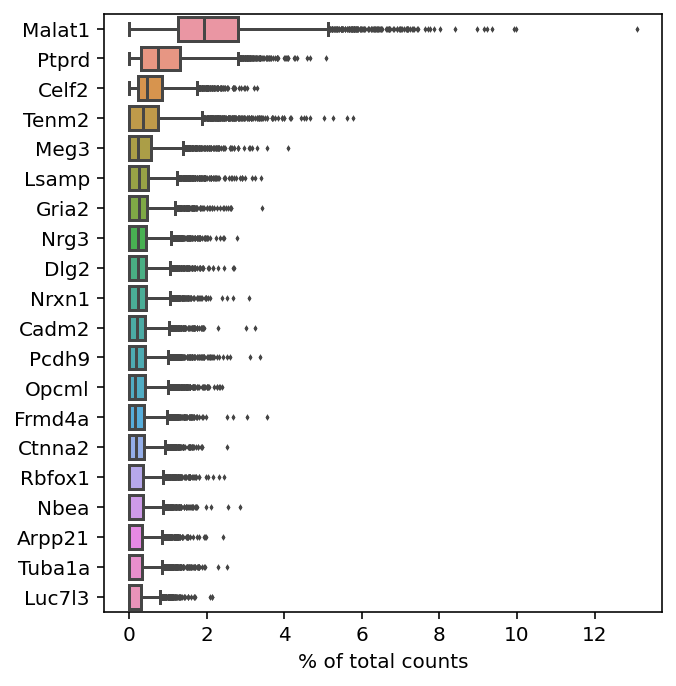

In [12]:
sc.pl.highest_expr_genes(scrna, n_top=20)

### Basic filtering

In [13]:
sc.pp.filter_cells(scrna, min_genes=1)
sc.pp.filter_genes(scrna, min_cells=1)
scrna

AnnData object with n_obs × n_vars = 5081 × 19322
    obs: 'Batch', 'Barcode', 'cell_type', 'n_genes'
    var: 'gene_symbols', 'n_cells'

In [14]:
scrna.raw = scrna

## Qalculate QC metrics including Mitochondrial genes

In [15]:
scrna.var['mt'] = scrna.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(scrna, qc_vars=['mt'], percent_top=None, inplace=True)
scrna

AnnData object with n_obs × n_vars = 5081 × 19322
    obs: 'Batch', 'Barcode', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

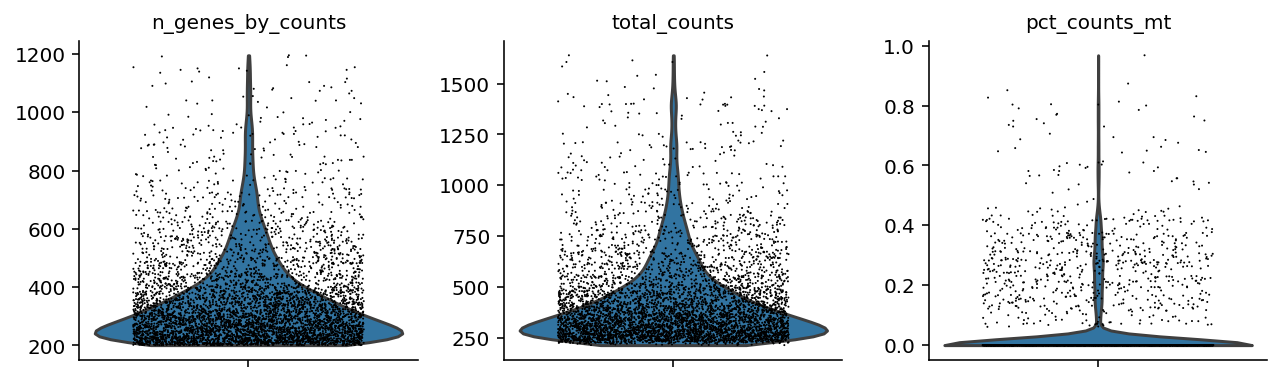

In [16]:
sc.pl.violin(scrna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.3, multi_panel=True)

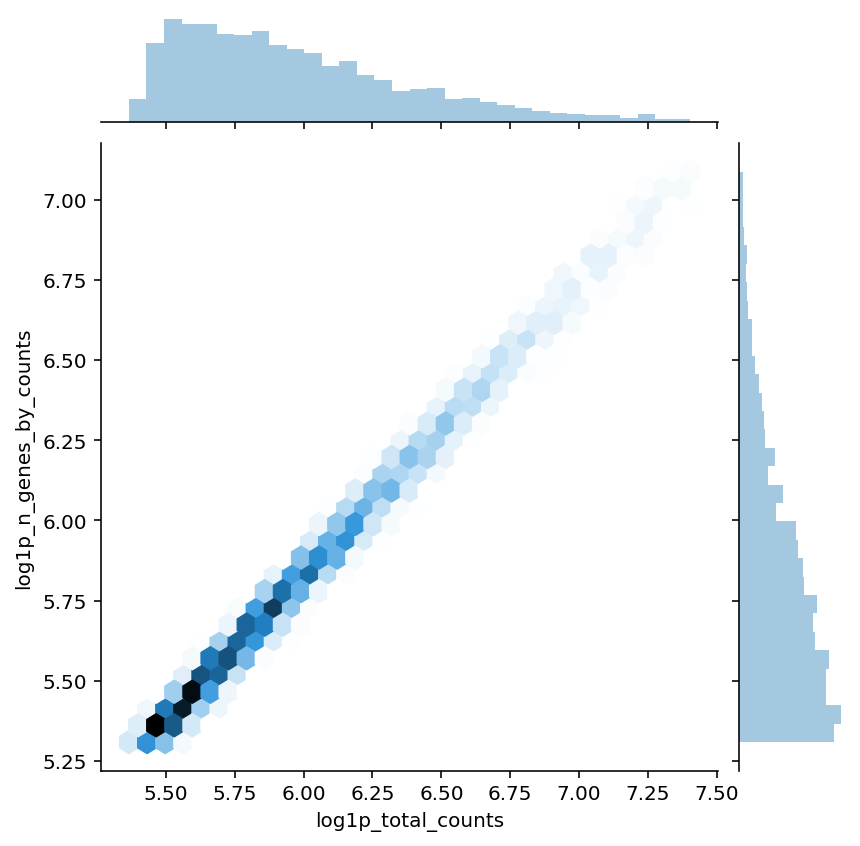

In [17]:
sns.jointplot("log1p_total_counts", "log1p_n_genes_by_counts", data=scrna.obs, kind='hex');

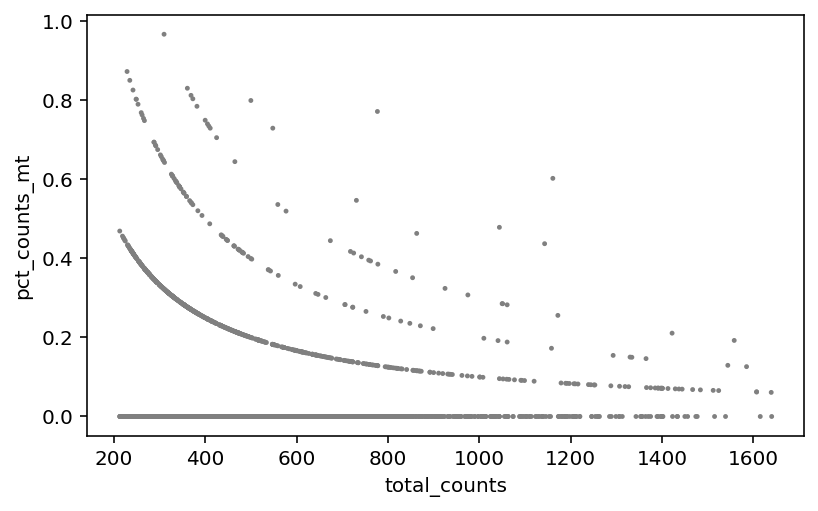

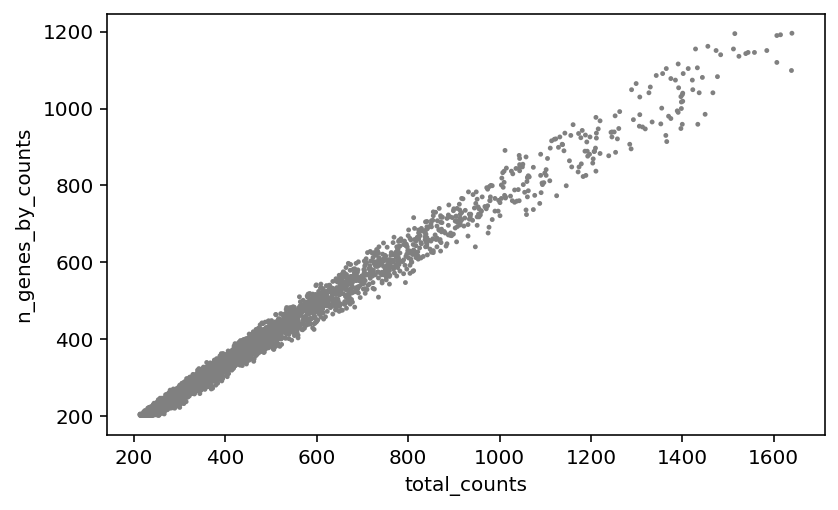

In [18]:
sc.pl.scatter(scrna, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(scrna, x='total_counts', y='n_genes_by_counts')

Filter out samples with high mitochondrial genes and highest number of genes:

In [19]:
sc.pp.filter_cells(scrna, min_genes=100)
sc.pp.filter_genes(scrna, min_cells=3)
scrna = scrna[scrna.obs.n_genes_by_counts < 1000, :]
scrna = scrna[scrna.obs.pct_counts_mt < 0.8, :]
scrna

View of AnnData object with n_obs × n_vars = 5027 × 15028
    obs: 'Batch', 'Barcode', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## Normalization

In [20]:
sc.pp.normalize_total(scrna, target_sum=1e4)
sc.pp.log1p(scrna)

## Filtering Highly Variable Genes

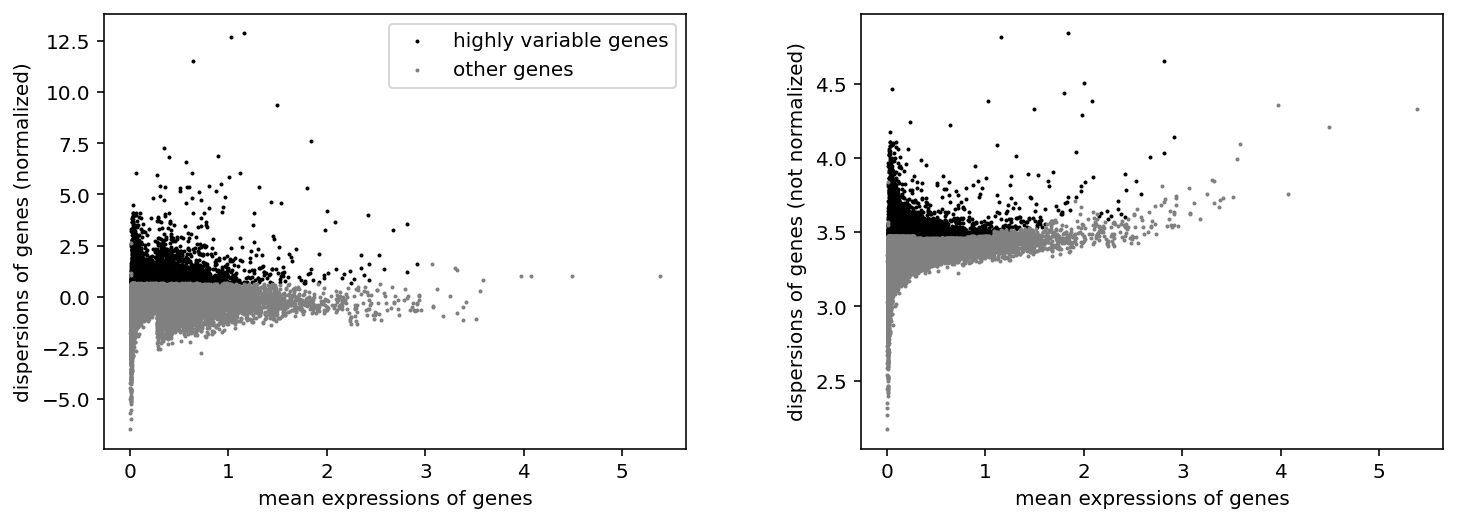

number of highly variable genes = 2925


In [21]:
sc.pp.highly_variable_genes(scrna, min_mean=0.01, max_mean=3, min_disp=0.65)
sc.pl.highly_variable_genes(scrna)
print('number of highly variable genes =', scrna.var.highly_variable.sum())

In [22]:
scrna = scrna[:, scrna.var.highly_variable]
scrna

View of AnnData object with n_obs × n_vars = 5027 × 2925
    obs: 'Batch', 'Barcode', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

## Visualization

In [23]:
sc.pp.neighbors(scrna)
sc.tl.umap(scrna)

         Falling back to preprocessing with `sc.pp.pca` and default params.


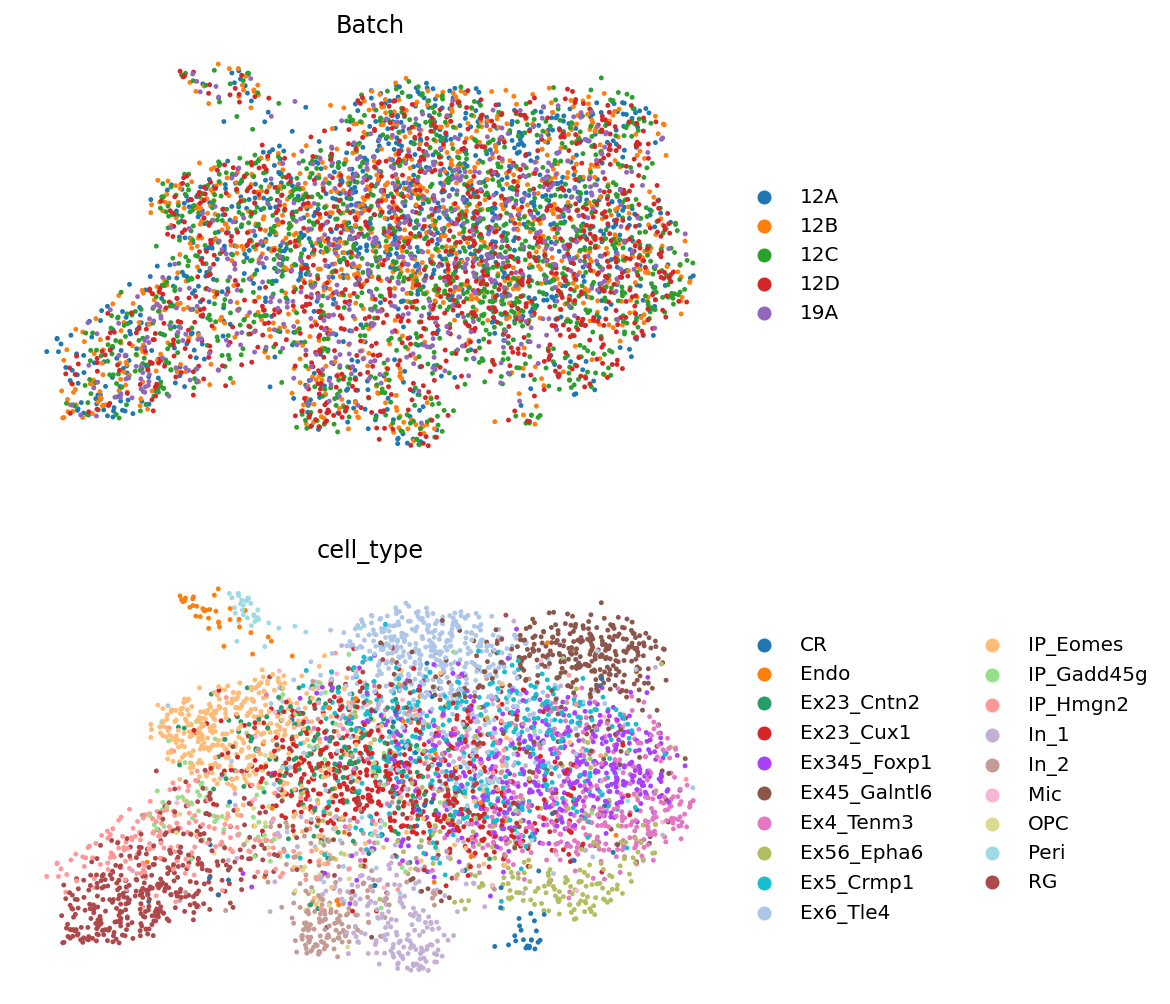

In [24]:
sc.pl.umap(scrna, color=['Batch', 'cell_type'], frameon=False, ncols=1)

---
# scATAC-seq Data

In [25]:
%%time
scatac = sc.read_10x_mtx(SCATAC_DIR, var_names='gene_symbols', cache=True)
scatac.obs = scatac.obs.join(metadata, how='left', sort=False)
scatac

CPU times: user 1.28 s, sys: 148 ms, total: 1.43 s
Wall time: 1.78 s


AnnData object with n_obs × n_vars = 5081 × 229429
    obs: 'Batch', 'Barcode', 'IdentChar'
    var: 'gene_ids'

In [26]:
scatac.obs.head()

,Batch,Barcode,IdentChar
TGGAATTTTCTC,12D,TGGAATTTTCTC,CR
CCAACAAACGCG,12B,CCAACAAACGCG,CR
TGCGCATAGCCG,12B,TGCGCATAGCCG,CR
CTGTTTCCCACC,12B,CTGTTTCCCACC,CR
ACAGTCTACATG,12B,ACAGTCTACATG,CR


In [27]:
scatac.var.head()

,gene_ids
chr1:3012650-3012823,chr1:3012650-3012823
chr1:3012853-3013002,chr1:3012853-3013002
chr1:3030589-3030826,chr1:3030589-3030826
chr1:3071552-3071701,chr1:3071552-3071701
chr1:3078770-3078919,chr1:3078770-3078919


## Data Cleaning

In [28]:
scatac.obs = scatac.obs.rename(columns={'IdentChar': 'cell_type'})

In [29]:
scatac.obs['Batch'] = scatac.obs['Batch'].astype('category')
scatac.obs['cell_type'] = scatac.obs['cell_type'].astype('category')

## Quality Control

### Basic filtering

In [30]:
epi.pp.filter_features(scatac, min_cells=1)
epi.pp.filter_cells(scatac, min_features=1)
scatac

AnnData object with n_obs × n_vars = 5081 × 229429
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells'

Save the raw data:

In [31]:
scatac.raw = scatac

## Visualization of the raw data

In [32]:
sc.pp.neighbors(scatac)
sc.tl.umap(scatac)

         Falling back to preprocessing with `sc.pp.pca` and default params.


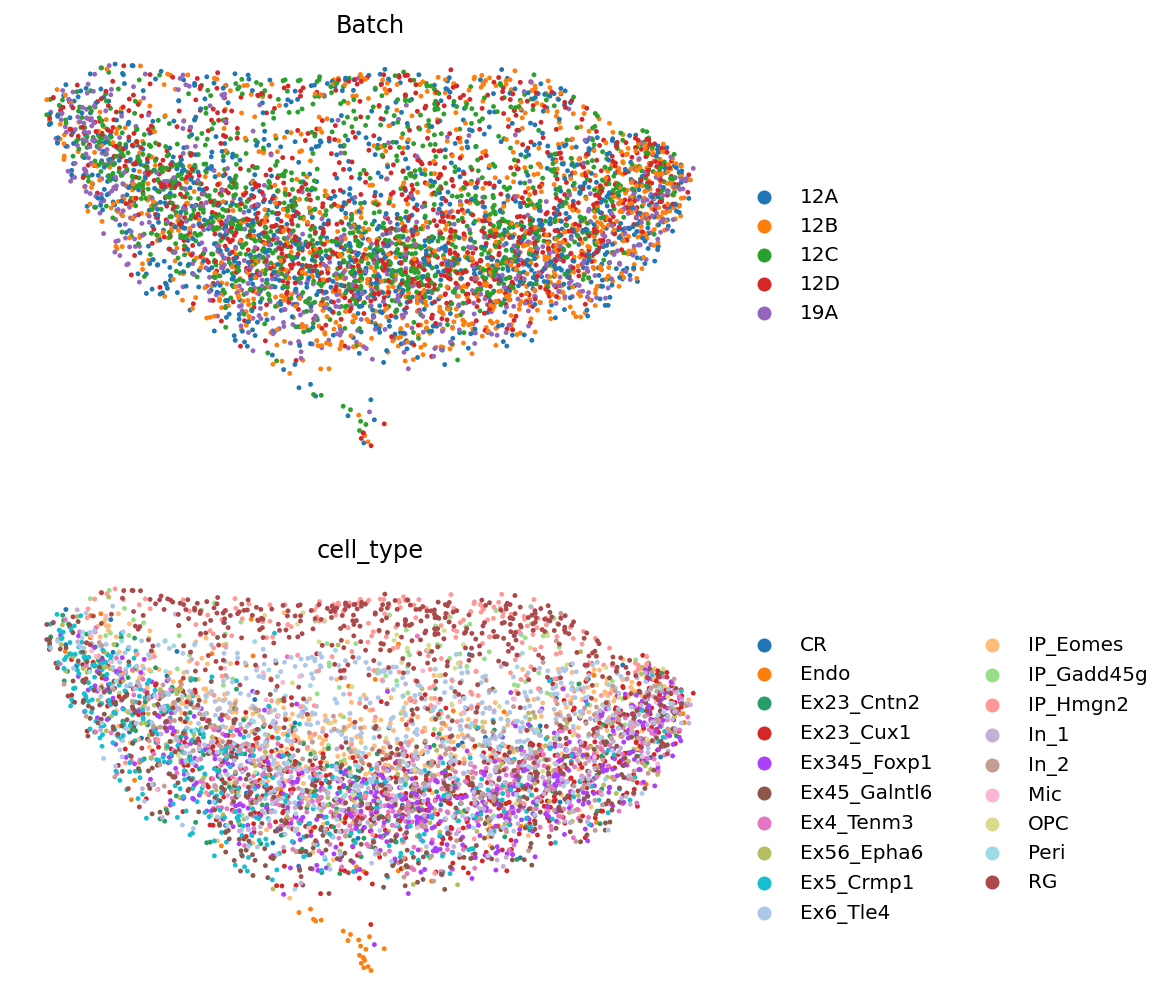

In [33]:
sc.pl.umap(scatac, color=['Batch', 'cell_type'], frameon=False, ncols=1)

## Binarization

In [34]:
%time scatac = epi.pp.binarize(scatac, copy=True)
scatac

CPU times: user 1.22 s, sys: 532 ms, total: 1.76 s
Wall time: 1.76 s


AnnData object with n_obs × n_vars = 5081 × 229429
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells'
    uns: 'neighbors', 'umap', 'Batch_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

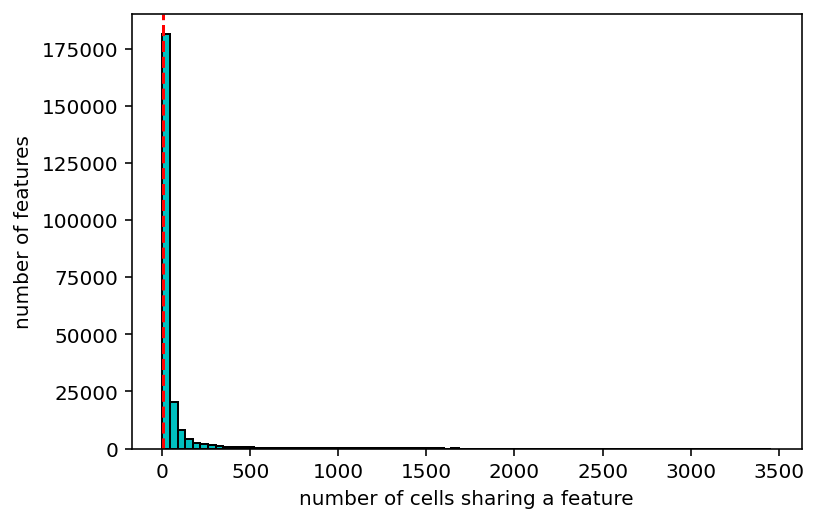

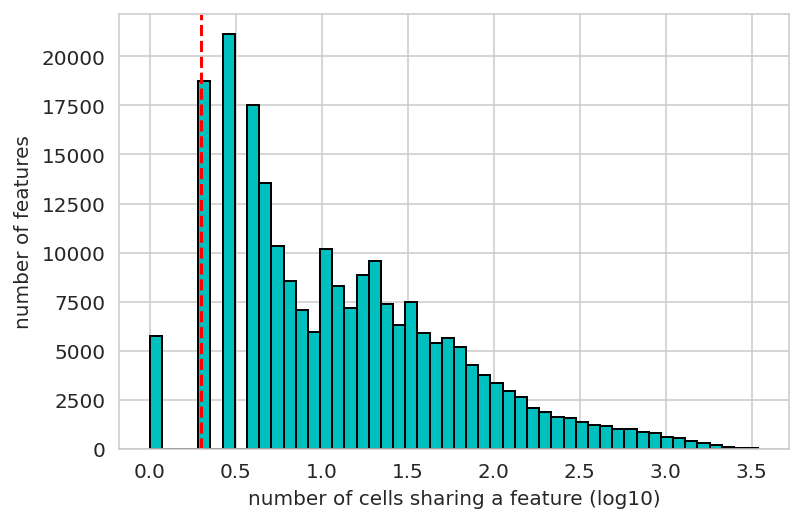

In [35]:
epi.pp.coverage_features(scatac, binary=True, log=False, bins=50, threshold=2)
epi.pp.coverage_features(scatac, binary=True, log=True, bins=50, threshold=2)

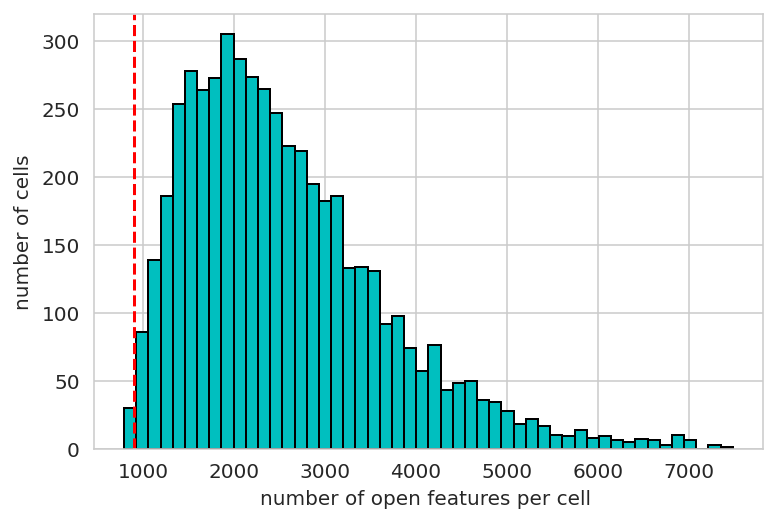

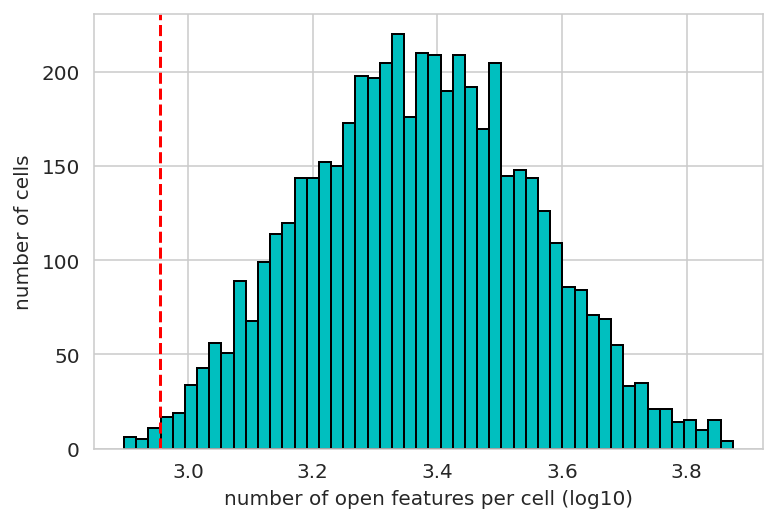

In [36]:
epi.pp.coverage_cells(scatac, binary=True, log=False, bins=50, threshold=900)
epi.pp.coverage_cells(scatac, binary=True, log=True, bins=50, threshold=900)

## Visualization of the raw binary data

In [37]:
sc.pp.neighbors(scatac)
sc.tl.umap(scatac)

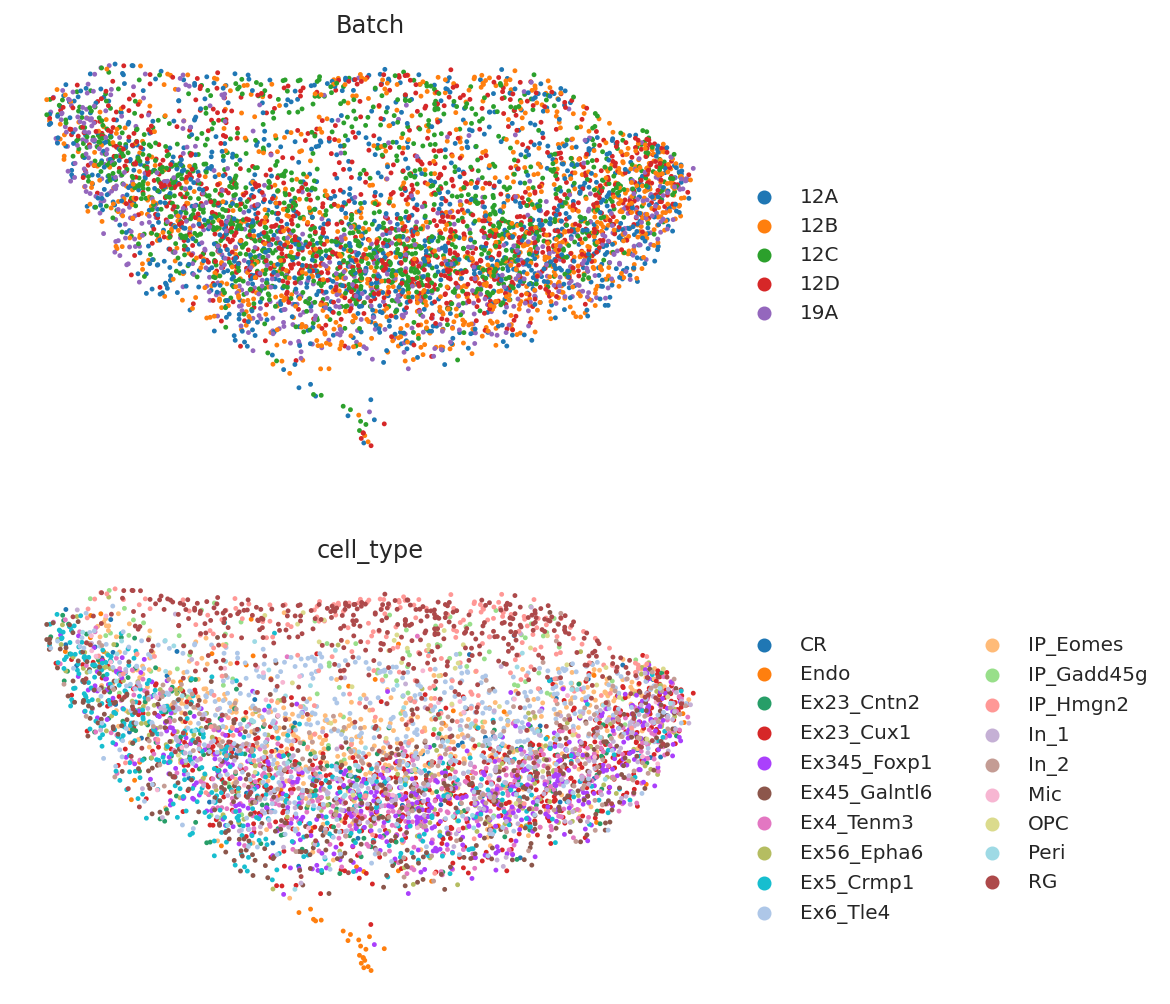

In [38]:
sc.pl.umap(scatac, color=['Batch', 'cell_type'], frameon=False, ncols=1)

## Filter low quality cells and peaks

In [39]:
epi.pp.filter_cells(scatac, min_features=900)
epi.pp.filter_features(scatac, min_cells=2)
scatac

AnnData object with n_obs × n_vars = 5060 × 223621
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells', 'commonness'
    uns: 'neighbors', 'umap', 'Batch_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [40]:
scatac.obs['nb_features'].describe()

count    5060.000000
mean     2565.428261
std      1093.387137
min       902.000000
25%      1755.750000
50%      2350.000000
75%      3152.250000
max      7487.000000
Name: nb_features, dtype: float64

In [41]:
scatac.var['commonness'].describe()

count    223621.000000
mean         58.103067
std         172.589944
min           2.000000
25%           4.000000
50%          11.000000
75%          36.000000
max        3457.000000
Name: commonness, dtype: float64

In [42]:
scatac.var['commonness'].median()

11.0

In [43]:
scatac = scatac[:, scatac.var['commonness'] > 11]
scatac

View of AnnData object with n_obs × n_vars = 5060 × 110645
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells', 'commonness'
    uns: 'neighbors', 'umap', 'Batch_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

## Selecting variable peaks

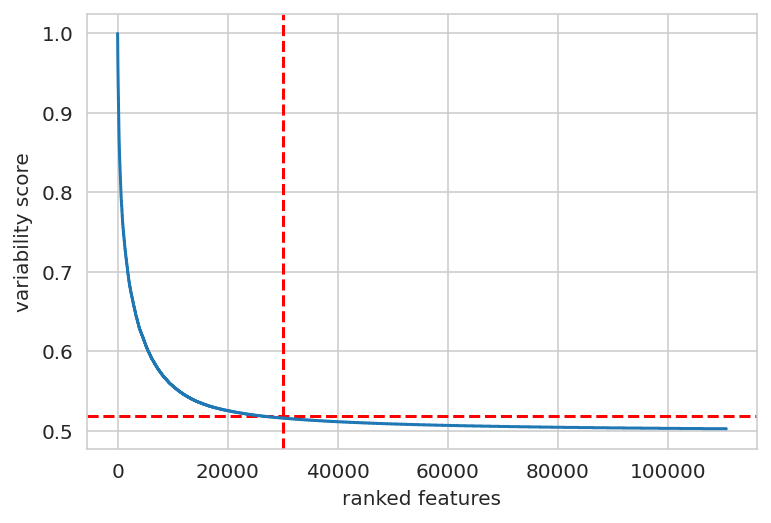

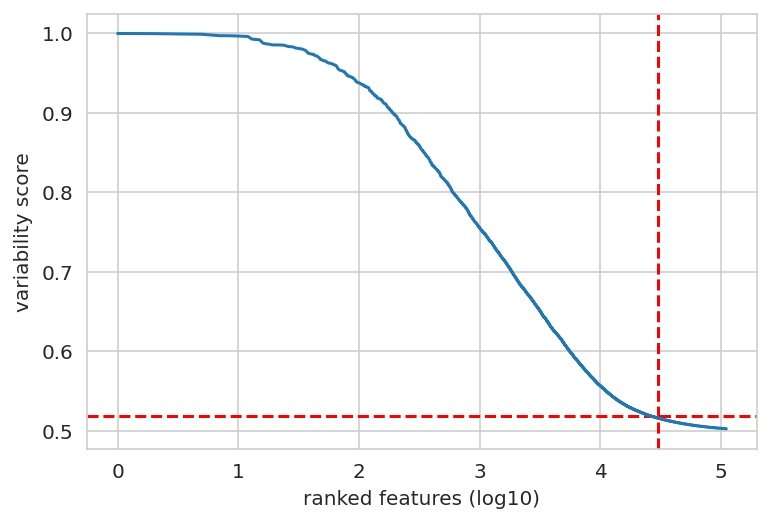

In [47]:
min_score_value = 0.518
nb_feature_selected = 30000
epi.pl.variability_features(scatac, log=None, min_score=min_score_value, nb_features=nb_feature_selected)
epi.pl.variability_features(scatac, log='log10', min_score=min_score_value, nb_features=nb_feature_selected)

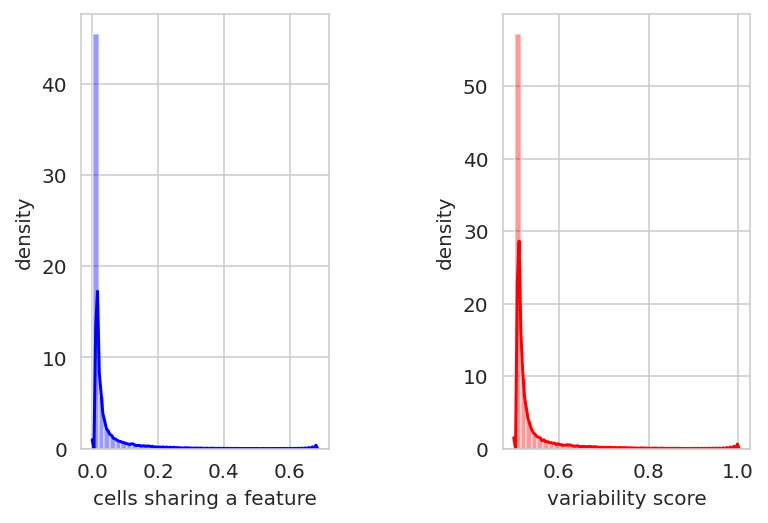

CPU times: user 1.4 s, sys: 244 ms, total: 1.64 s
Wall time: 1.64 s


In [48]:
%time scatac = epi.pp.select_var_feature(scatac, nb_features=nb_feature_selected, copy=True)

In [49]:
scatac

View of AnnData object with n_obs × n_vars = 5060 × 30298
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'neighbors', 'umap', 'Batch_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

## Visualization

In [50]:
sc.pp.neighbors(scatac)
sc.tl.umap(scatac)

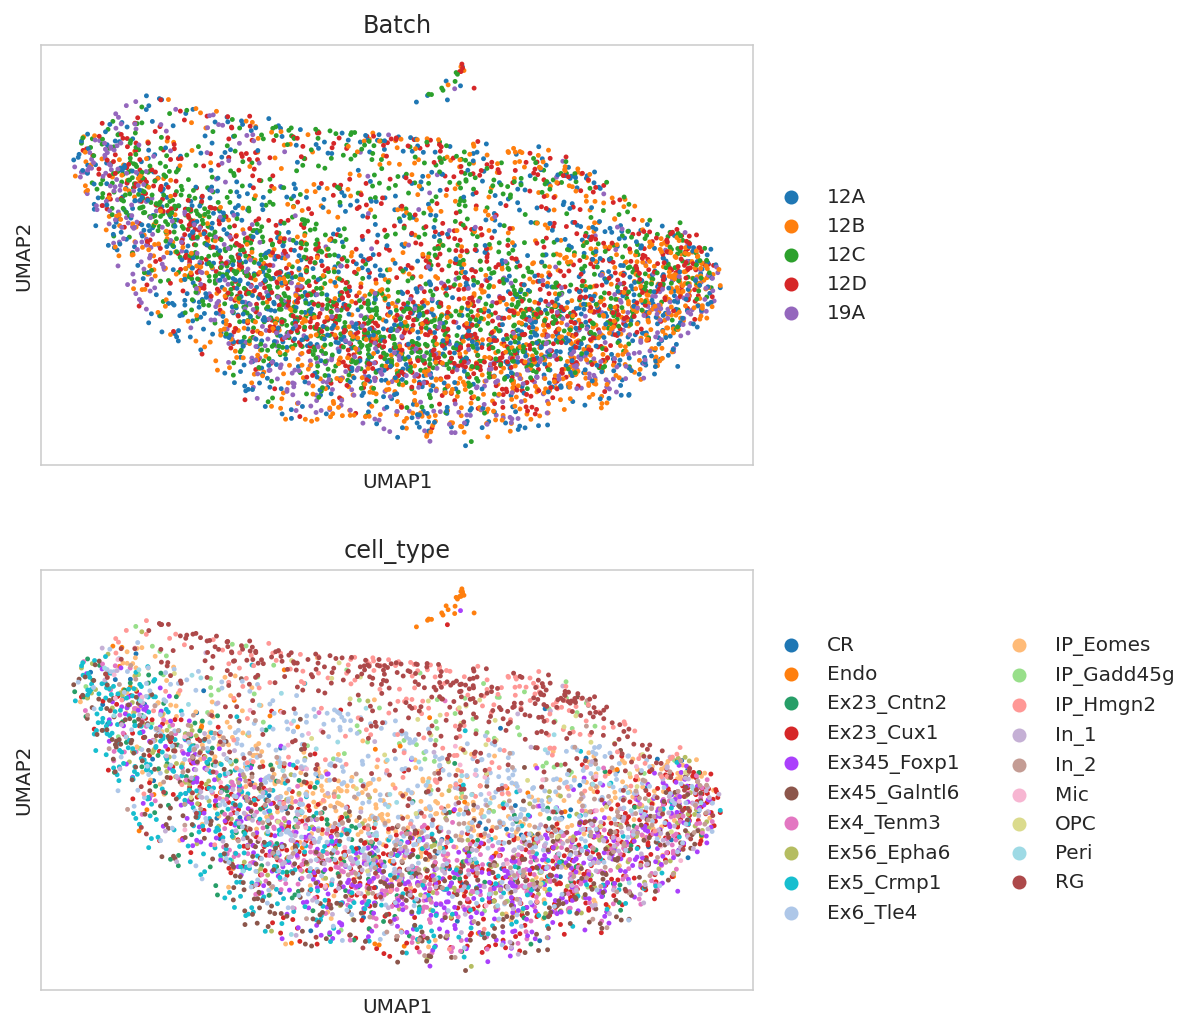

In [51]:
sc.pl.umap(scatac, color=['Batch', 'cell_type'], ncols=1)

---
# Save the results

### Find common paired samples

In [52]:
com_index = set(scrna.obs.index) & set(scatac.obs.index)
scrna = scrna[scrna.obs.index.isin(com_index)]
scatac = scatac[scatac.obs.index.isin(com_index)]
print(scrna.shape, scatac.shape)

(5006, 2925) (5006, 30298)


In [53]:
%time scrna.write(SCRNA_DIR + 'expressions.h5ad')

CPU times: user 312 ms, sys: 40 ms, total: 352 ms
Wall time: 710 ms


In [54]:
%time scatac.write_h5ad(SCATAC_DIR + 'peaks-binary.h5ad')

CPU times: user 3.41 s, sys: 276 ms, total: 3.68 s
Wall time: 5.29 s
